In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import boxcox1p
from scipy.stats import probplot, skew, pearsonr

from category_encoders import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import EllipticEnvelope
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import logging
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

#### 1. Load data

In [2]:
folderPath = "../data/"
train = pd.read_csv(folderPath + "train.csv")  
test = pd.read_csv(folderPath + "test.csv")  
print(train.shape)
train.head(2)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


#### 2. EDA
- Check missing data
- Check for outliers
- Skewness analysis of target & feature distributions
- Convert categorical coding to numerical encoding

##### Missing data ------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(10)

In [4]:
checkMissingData(train)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


- remove features with missing data > 40% & impute mean value into LotFrontage

In [4]:
train.drop(['PoolQC', 'MiscFeature', 'Alley', 'FireplaceQu', 'Fence'], axis=1, inplace = True)

- remove features with missing data > 40% & impute mean value into LotFrontage based on its own neighbourhood

In [5]:
# df_ = train.groupby(["Neighborhood"]).LotFrontage.mean()
# train[train.LotFrontage.isnull() == True].Neighborhood
# train['LotFrontage'].fillna(train['LotFrontage'].mean(), inplace=True)
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

In [6]:
checkMissingData(train)

,Total,Percent
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342


- 81 'Garage' variables are missing probably reflecting those houses without a garage
        - fill with 'NotAvail'

In [6]:
garage_cols = ['GarageType','GarageFinish', 'GarageCars','GarageQual', 'GarageCond']
train[garage_cols] = train[garage_cols].fillna('NotAvail')

- Recheck updated missing data

In [7]:
checkMissingData(train)

,Total,Percent
GarageYrBlt,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrArea,8,0.005479
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000


- Scale GarageYrBlt to values between 0 and 1 and set missing values to '0' 
        - thereby having little influence as a feature as they are literally houses with no garage

In [8]:
X = train.values
ct = ColumnTransformer([("mm", MinMaxScaler(), ['GarageYrBlt'])])
train.GarageYrBlt = ct.fit_transform(train)
train.GarageYrBlt = train.GarageYrBlt.fillna(0)
checkMissingData(train)

,Total,Percent
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
RoofStyle,0,0.000000


- The missing basement & MasVnr variables are for houses presumably without basements & masonry veneers: 
        - thereby having little influence as a feature as they are literally houses with no garage
        - use same method as before: type in "NotAvail"
        - replace missing electrical value with most common type

In [9]:
cols = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtCond', 'BsmtQual', 'MasVnrType']
train.MasVnrArea.fillna(value='NotAvail', inplace=True)
for col in cols:
    train[col].fillna(value='NotAvail', inplace=True)
train.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [10]:
#train[train['BsmtExposure']].fillna(value='NotAvail', inplace=True)
train.Electrical.fillna(value='SBrkr', inplace=True)
checkMissingData(train).head(1)

,Total,Percent
SalePrice,0,0.0


*No more missing data*

##### Outlier detection for continuous variables --------------------------------------------------------------------------------------------------------------------------------

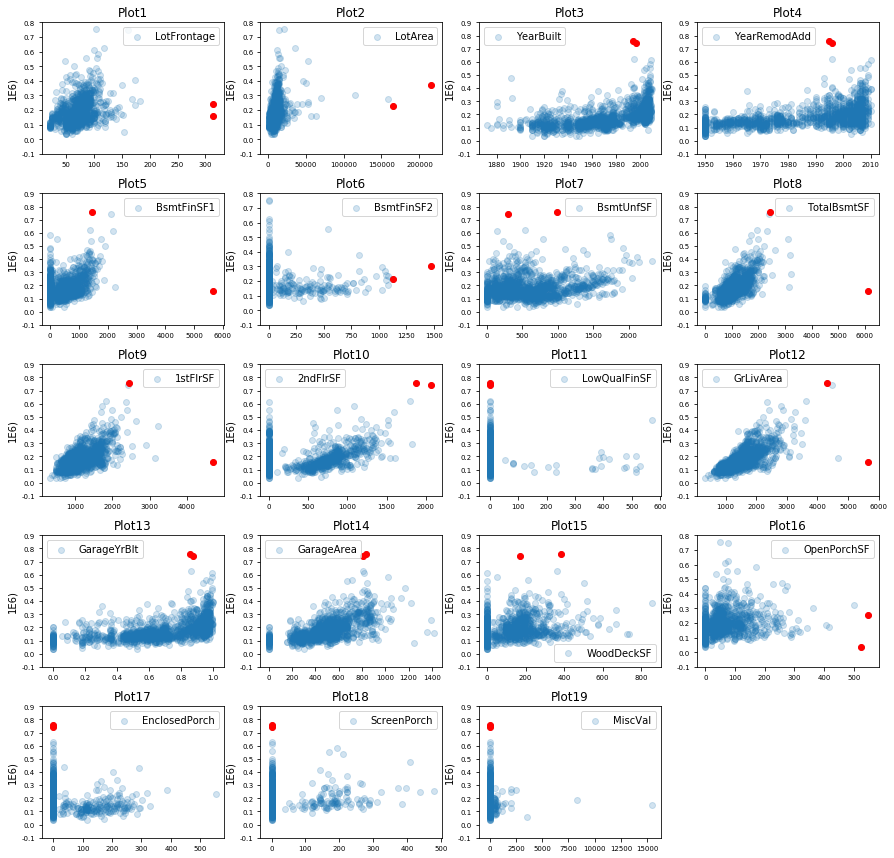

In [11]:
colList = []
count = 0
for i, col in enumerate(train.columns):
    if (i != 0) & ((train[col].dtype == 'int64') | (train[col].dtype == 'float64') ) & (col != 'SalePrice'):
        # Only consider continous variables
        if len(train[col].value_counts()) > 20:
            colList.append(col)
            count += 1

rows = int(np.ceil(len(colList) / 4))    # 4 plots per row
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    axi = f.add_subplot(rows, 4, i+1)
    plt.scatter(train[col], train.SalePrice, label = col, alpha = 0.2)
    df = train[[col, 'SalePrice']]
    X = df.values
    elenv = EllipticEnvelope(contamination=.001)
    pred = elenv.fit_predict(X)
    anom_index = np.where(pred==-1)
    values = X[anom_index]

    plt.scatter(values[:,0],values[:,1], color='r')
    plt.title("Plot" + str(i+1))
    axi.tick_params(axis="x", labelsize=7)
    axi.tick_params(axis="y", labelsize=7)
    locs,labels = plt.yticks()
    plt.yticks(locs, map(lambda x: "%.1f" % x, locs/1e6))
    plt.ylabel('1E6)')
    plt.legend()
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

*Assuming a contamination of outliers in the dataset of 0.1% the above red datapoints have been suggested as outliers according to sklearn's "elliptic envelope"* <br> From the above plots it seems only appropriate to consider those in plots 2, 3, 8, 11, 12, 15, 28 & 33"  

In [12]:
train_ = train.copy()
# Plot1
train_ = train_[(train_.LotFrontage < 300)]
# Plot2
train_ = train_[(train_.LotArea < 150000)]
# Plot5
train_ = train_[(train_.BsmtFinSF1 < 5000)]   
# Plot8
train_ = train_[(train_.TotalBsmtSF < 6000)]  
# Plot9
train_ = train_[(train_['1stFlrSF'] < 4000)]    
# Plot12
train_ = train_[(train_.GrLivArea < 5000)]    
# Plot16
train_ = train_[(train_.OpenPorchSF < 500)]   
# Plot19
train_ = train_[(train_.MiscVal < 15000)]

# Examine size of data with outliers removed vrs those without
print('Deleted {} points.'.format(train.shape[0] - train_.shape[0]))
train.shape, train_.shape                                      

Deleted 9 points.


((1460, 76), (1451, 76))

##### Check skewness of target variable --------------------------------------------------------------------------------------------------------------------------------------------
        - correct with log of target

In [13]:
def plotDistrib(df_):
    df = df_.copy()
    f = plt.figure(figsize=(15,4))
    label_ = 'original'
    for i in range(0, 4):
        axi = f.add_subplot(2, 2, i+1)
        if i%2 == 0:
            sns.distplot(df['SalePrice'], ax= axi)#label = label_)
        else:
            res = probplot(df['SalePrice'], plot=axi)#label = label_)
        
        plt.legend(title=label_, loc='upper left')
        if i == 1:
            label_ = 'log_transform'
            #print("Skewness: %f" % df['SalePrice'].skew())
            #print("Kurtosis: %f" % df['SalePrice'].kurt())
            df["SalePrice"] = np.log(df['SalePrice'])
            #print("Skewness: %f" % df['SalePrice'].skew())
            #print("Kurtosis: %f" % df['SalePrice'].kurt())
            
        #, labels=['Hell Yeh', 'Nah Bruh'])
            
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.60)

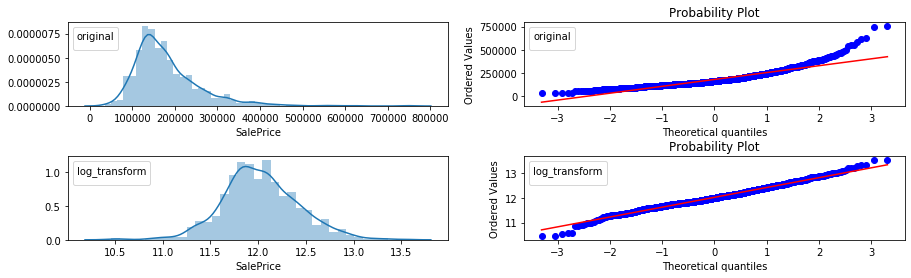

In [14]:
train_ = train.copy()
plotDistrib(train_)
train['SalePrice'] = np.log(train_['SalePrice'])

##### Check skewness of continous features: -----------------------------------------------------------------------------------------------------------------------------------
*'If you log transform the response variable, it is required to also log transform feature variables that are skewed."* <br>
https://becominghuman.ai/how-to-deal-with-skewed-dataset-in-machine-learning-afd2928011cc

In [15]:
# Check the skew of all continuous features ('colList' defined above)
def checkSkewness(df, colList_):
    skewed_feats = df[colList_].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features:")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    return skewness

In [18]:
skewDf = checkSkewness(train, colList)
skewDf.head()


Skew in numerical features:


,Skew
MiscVal,24.451640
LotArea,12.195142
LowQualFinSF,9.002080
BsmtFinSF2,4.250888
ScreenPorch,4.117977


*Box-Cox transformation 'boxcox1p' to attempt removal of some skewness*

In [16]:
df = train.copy()

In [19]:
skewDf = skewDf[abs(skewDf.Skew) > 2] ## Assume skewness level above 2 is considered
#print("There are {} relatively skewed numerical features to Box Cox transform".format(skewDf.shape[0]))

skewed_features = skewDf.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

# Check the skew of updated features
skewDf = checkSkewness(train, colList)
skewDf.head(5)


Skew in numerical features:


,Skew
LowQualFinSF,7.593301
MiscVal,5.505530
ScreenPorch,3.184431
BsmtFinSF2,2.619350
EnclosedPorch,2.160966


*Skewness has been reduced to more reasonable levels*

##### Check correlations / multicollinearity within datasets: ----------------------------------------------------------------------------------------------------------------

*There is certainly a real risk of multicollinearity between features within this dataset. For example 'Garage' variables alone will be highly correlated with eachother.*<br>
In order to reduce this risk, tree-based algorithms will only be used in the presence of multi-collinear data. Otherwise for algorithms susceptible to this problem (i.e. linear regression), preprocessing on the dataset via PCA-based feature reduction will be introduced. Algorithms with susceptibility to multicollinearity will only be subject to the PCA-reduced dataset.
*Here several approaches will be demonstrated:* <br>

1. Dataset with PCA-based feature reduction to remove multicollinearity
2. Original dataset for tree-based algorithms that do not exhibit same risks of multicollinearity
3. Tree-based algorithms will also be trialed on the PCA-dataset

*Additionally various representations of categorical features will be explored*
    - numerical encoding, binary encoding and one-hot encoding

##### Categorical to numerical encoding: ---------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
cat_vars = train.dtypes[train.dtypes == "object"].index
for i, var in enumerate(cat_vars):
    #print(var)
    train[var] = train[var].astype('category')
    train[var] = train[var].cat.codes

Keep backup of original numerical-encoded train

In [28]:
train_num = train.copy()

In [27]:
df_correl = checkTargetVarCorrel(train)
print('Top {} features with direct correlation to target variable: '.format(20))
df_correl.head(20)

Top 20 features with direct correlation to target variable: 


,Var,Variable
0,OverallQual,0.82
1,GrLivArea,0.70
2,GarageCars,0.68
3,GarageArea,0.65
4,TotalBsmtSF,0.61
5,1stFlrSF,0.60
6,YearBuilt,0.59
7,FullBath,0.59
8,GarageYrBlt,0.59
9,YearRemodAdd,0.57


*There will most likely be some multicollinearity in this dataset due to similar features (i.e. Garage features). Similar features will be examined for collinearity and those with less correlation to the target variable but high levels of multicollinearity will be removed. A backup of the original datasets will be kept.*

In [25]:
train_old = train.copy() # backup

In [310]:
train = train_old.copy() # backup

- Examine 'Garage' variables

In [26]:
colList = ['SalePrice']
for i, col in enumerate(train):
        if 'Garage' in col:
            colList.append(col)
df_ = train[colList]
checkVarInfFactor(df_)
checkPearsonCorrel(df_)

GarageYrBlt = 2.82, GarageCars = 5.14, GarageArea = 4.71, 

SalePrice  &  GarageType  with correlation coeff =  -0.5
SalePrice  &  GarageYrBlt  with correlation coeff =  0.59
SalePrice  &  GarageFinish  with correlation coeff =  -0.42
SalePrice  &  GarageCars  with correlation coeff =  0.68
SalePrice  &  GarageArea  with correlation coeff =  0.65
SalePrice  &  GarageQual  with correlation coeff =  0.28
SalePrice  &  GarageCond  with correlation coeff =  0.32


Drop 'GarageArea' and see if multicollinearity improves - 'GarageCond' does not appear to have multicollinearity with counterparts

In [312]:
train.drop(['GarageArea'], axis = 1, inplace = True)
colList = ['SalePrice']
for i, col in enumerate(train):
        if 'Garage' in col:
            colList.append(col)
df_ = train[colList]
checkVarInfFactor(df_)

GarageYrBlt = 2.73, 



Remove 'GarageYrBlt' & risk of multicollinearity should be reduced

In [313]:
train.drop(['GarageYrBlt'], axis = 1, inplace = True)
colList = ['SalePrice']
for i, col in enumerate(train):
        if 'Garage' in col:
            colList.append(col)
df_ = train[colList]
checkVarInfFactor(df_)

- Examine 'Bsmt' variables (Basement)

In [314]:
colList = ['SalePrice']
for i, col in enumerate(train):
        if 'Bsmt' in col:
            colList.append(col)
df_ = train[colList]
checkVarInfFactor(df_)
checkPearsonCorrel(df_)

BsmtFinSF1 = 3.79, BsmtFinType2 = 3.83, BsmtFinSF2 = 4.39, BsmtUnfSF = 3.50, TotalBsmtSF = 3.11, 

SalePrice  &  BsmtFinSF1  with correlation coeff =  0.37
SalePrice  &  TotalBsmtSF  with correlation coeff =  0.45


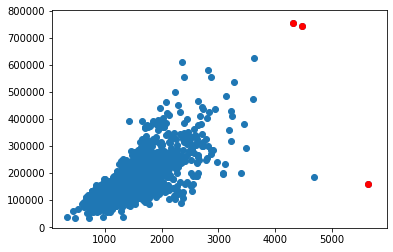

'\nprint(elenv)\n\nEllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,\n                 store_precision=True, support_fraction=None) \n\n\narr = cov.predict(X)\nplt.plot(arr, df.SalePrice)'

In [87]:
df = train[['GrLivArea', 'SalePrice']]
X = df.values
#cov = EllipticEnvelope(random_state=0).fit(X)
elenv = EllipticEnvelope(contamination=.002)
pred = elenv.fit_predict(X)


#Next, we'll extract the negative outputs as the outliers.

anom_index = np.where(pred==-1)
values = X[anom_index]


#Finally, we'll visualize the results in a plot by highlighting the anomalies with a color.

plt.scatter(X[:,0], X[:,1])
plt.scatter(values[:,0],values[:,1], color='r')
plt.show()

'''
print(elenv)

EllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,
                 store_precision=True, support_fraction=None) 


arr = cov.predict(X)
plt.plot(arr, df.SalePrice)'''

In [80]:
arr.shape

(1460,)

In [43]:
type(train.Id.dtype)

str

In [44]:
train.Id.dtype == 'int64'

True

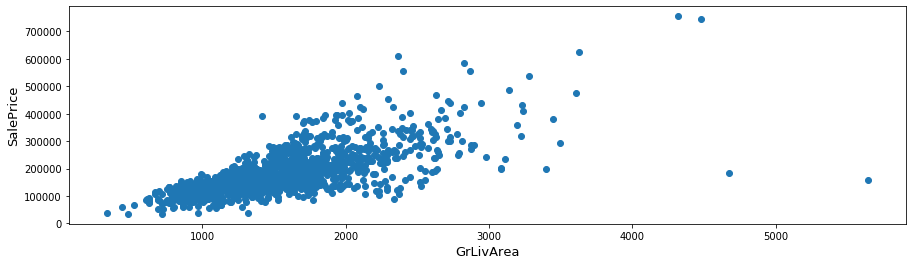

In [20]:
fig, ax = plt.subplots(figsize=(15,4))
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [22]:
# Check higher variance inflation factors
def checkVarInfFactor(df):
    # For each X, calculate VIF and save in dataframe
    #array = df.values
    #X = array[:,1:(df.shape[1] - 1)]
    #Y = array[:,(df.shape[1] - 1)]
    #X = df.copy()
    df_ = df.drop(['SalePrice'], axis=1)
    X = add_constant(df_)

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Display Features with High Variance Inflation Factor
    corrFeatures = []
    corrFeatures.append("SalePrice")
    for i in range(0, len(vif["features"] )):
        if vif["VIF Factor"][i] > 2.5 and vif["features"][i] != "const":
            print("{} = {:.2f}".format(vif["features"][i], vif["VIF Factor"][i]), end = ', ')   
            corrFeatures.append(vif["features"][i])
    print('\n')
            
# Check Pearson's correlation coefficient of variables without visualising entire heatmap
def checkPearsonCorrel(df):
    for i, feat in enumerate(df.columns):
        for j, feat_ in enumerate(df.columns):
            if (feat == 'SalePrice') & (feat_ != 'SalePrice'):
                pearson_coeff = round(pearsonr(df[feat], df[feat_])[0], 2)
                print(feat, " & ", feat_, " with correlation coeff = ",  pearson_coeff)

def checkTargetVarCorrel(df):
    lstCorrelRanks = []
    for i, col in enumerate(df):
        if col != 'SalePrice':
            #print(type(df[col].values[0]), col)
            pearson_coeff = round(pearsonr(df['SalePrice'], df[col])[0], 2)
            lstCorrelRanks.append([col, pearson_coeff])
            #print(col, pearson_coeff)
    df_correl = pd.DataFrame(lstCorrelRanks, columns = ['Var', 'Variable'])
    df_correl.sort_values(by = 'Variable', ascending = False, inplace = True)
    df_correl.reset_index(drop = True, inplace = True)
    return df_correl
            